In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import os
import time

from PIL import Image

import umap
import pickle
from math import *

DEVICE = "cuda"

def tovar(x):
    return torch.FloatTensor(x).to(DEVICE)

In [3]:
class Triplet(nn.Module):
    def __init__(self):
        super(Triplet,self).__init__()
        
        self.l1a = nn.Conv3d(3,32,5,padding=2)
        nn.init.orthogonal_(self.l1a.weight, gain=sqrt(2))
        self.b1a = nn.BatchNorm3d(32)
        self.l1b = nn.Conv3d(32,32,5,padding=2)
        self.b1b = nn.BatchNorm3d(32)
        nn.init.orthogonal_(self.l1b.weight, gain=sqrt(2))
        self.p1 = nn.MaxPool3d(2)
        
        self.l2a = nn.Conv3d(32,64,5,padding=2)
        self.b2a = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2a.weight, gain=sqrt(2))
        self.l2b = nn.Conv3d(64,64,5,padding=2)
        self.b2b = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2b.weight, gain=sqrt(2))
        self.p2 = nn.MaxPool3d(2)

        self.l3a = nn.Conv3d(64,128,5,padding=2)
        self.b3a = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3a.weight, gain=sqrt(2))
        self.l3b = nn.Conv3d(128,128,5,padding=2)
        self.b3b = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3b.weight, gain=sqrt(2))
        self.p3 = nn.MaxPool3d(2)
        
        self.l4a = nn.Conv3d(128,256,5,padding=2)
        self.b4a = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4a.weight, gain=sqrt(2))
        self.l4b = nn.Conv3d(256,256,5,padding=2)
        self.b4b = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4b.weight, gain=sqrt(2))
        self.p4 = nn.MaxPool3d(2)
        
        self.l5 = nn.Linear(256,16,1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        z = x
        z = F.leaky_relu(self.l1a(z))
        z = self.b1a(z)
        z = F.leaky_relu(self.l1b(z))
        z = self.b1b(z)
        z = self.p1(z)
        
        z = F.leaky_relu(self.l2a(z))
        z = self.b2a(z)
        z = F.leaky_relu(self.l2b(z))
        z = self.b2b(z)
        z = self.p2(z)
        
        z = F.leaky_relu(self.l3a(z))
        z = self.b3a(z)
        z = F.leaky_relu(self.l3b(z))
        z = self.b3b(z)
        z = self.p3(z)
        
        z = F.leaky_relu(self.l4a(z))
        z = self.b4a(z)
        z = F.leaky_relu(self.l4b(z))
        z = self.b4b(z)
        z = self.p4(z).mean(4).mean(3).mean(2)
        
        z = self.l5(z)
        z = z/torch.sqrt(torch.sum(z**2,1)+1e-4).unsqueeze(1)
        
        return z
    
net = Triplet().cuda()
net.load_state_dict(torch.load("triplet_ca_2d_multitype.pth"))
net.eval()

clf = pickle.load(open("umap_classifier_multi.pkl","rb"))

In [7]:
class Node():
    def __init__(self, k, depth, maxdepth=3):
        super().__init__()
        
        self.variable = np.random.randint(k+1)
        if self.variable == 0:
            self.threshold = np.random.randint(k)
        else:
            self.threshold = np.random.randint(9)
            
        self.operation = np.random.randint(2) # Equality, >=
        
        if depth == maxdepth:
            self.children = [np.random.randint(k), np.random.randint(k)]
            self.leaf = True
        else:
            self.children = [Node(k,depth+1,maxdepth), Node(k,depth+1,maxdepth)]        
            self.leaf = False
            
    def forward(self, x):
        if self.operation == 0:
            if x[self.variable] == self.threshold:
                branch = 1
            else:
                branch = 0
        elif self.operation == 1:
            if x[self.variable] >= self.threshold:
                branch = 1
            else:
                branch = 0
        
        if self.leaf:
            return self.children[branch]
        else:
            return self.children[branch].forward(x)
        
class CA():
    def __init__(self, colors = 3, XR = 128, YR = 128, TR = 128):
        self.rgb = np.random.rand(colors,3)
        self.state = torch.LongTensor(np.random.randint(colors, size=(XR,YR)).astype(np.int32)).to(DEVICE)
        
        self.history = np.zeros((XR,YR,TR)).astype(np.int32)
        
        self.colors = colors
        self.XR = XR
        self.YR = YR
        self.TR = TR
        # 8 neighbor outer symmetric
        # 
        # k (center) * 7^k (outer [0,1,2,3,4] for each color)
        self.transitions = torch.LongTensor(np.random.randint(colors, size=(colors * 9**(colors)))).to(DEVICE)
        self.idx = torch.arange(XR*YR).long().to(DEVICE)
    
    def tree_transition(self, depth=3):
        tree = Node(self.colors, 1, depth)
        transitions = np.zeros((self.colors * 9**self.colors))
        
        for i in range(self.colors * 9**self.colors):
            idx = np.zeros((1+self.colors,)).astype(np.int32)
            
            mult = 1
            idx[0] = (i//mult)%self.colors
            mult *= self.colors
            for k in range(self.colors):
                idx[k+1] = (i//mult)%9
                mult *= 9
            
            transitions[i] = tree.forward(idx)
        
        self.transitions = torch.LongTensor(transitions).to(DEVICE)
    
    def runca(self):
        for t in range(self.history.shape[2]):
            padstate = torch.cat([self.state[-1:,:], self.state, self.state[:1,:]], 0)
            padstate = torch.cat([padstate[:,-1:], padstate, padstate[:,:1]], 1)
            
            self.history[:,:,t] = self.state.cpu().detach().numpy()
            
            multiplier = self.colors
            indices = self.state.view(self.XR*self.YR)
            
            histogram = torch.zeros((self.XR*self.YR, self.colors)).long().to(DEVICE)
            
            shiftstate = padstate[:-2,1:-1].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
            shiftstate = padstate[2:,1:-1].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
            shiftstate = padstate[1:-1,:-2].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
            shiftstate = padstate[1:-1,2:].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
            
            shiftstate = padstate[:-2,:-2].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
            shiftstate = padstate[:-2,2:].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
            shiftstate = padstate[2:,:-2].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
            shiftstate = padstate[2:,2:].contiguous().view(self.XR*self.YR)
            histogram[self.idx, shiftstate[self.idx]] += 1
                        
            for k in range(self.colors):
                indices += multiplier * histogram[:,k] 
                multiplier *= 9
            
            self.state = self.transitions[indices].view(self.XR, self.YR)

def totensor(history, rgb):
    XR = history.shape[1]
    YR = history.shape[0]
    TR = history.shape[2]
    
    hist = history.transpose(1,0,2).reshape((XR*YR*TR))
    
    im = 2*rgb[hist]-0.5
    im = im.transpose(1,0).reshape((1,3,XR,YR,TR))
    return tovar(im)

def render(history,rgb):    
    XR = history.shape[1]
    YR = history.shape[0]
    
    hist = history.transpose(1,0).reshape((XR*YR))
    im = np.clip(256*rgb[hist],0,255).astype(np.uint8)
    im = im.reshape((XR,YR,3))
    im = Image.fromarray(im)
    return im

def generate_palette(k):
    stop = False
    
    while not stop:
        rgb = np.random.rand(k,3)
        dist = np.sum(np.abs(rgb[np.newaxis,:,:] - rgb[:,np.newaxis,:]),axis=2)
        dist[np.arange(k), np.arange(k)] += 10
        mindist = np.min(dist)
        if mindist > 0.75:
            stop = True
    
    return rgb

In [5]:
!mkdir data4_2d

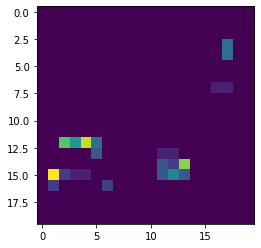

In [ ]:
from IPython import display
import time

UMIN = -10
UMAX = 16
VMIN = -10
VMAX = 16
BINS = 20

#density = np.ones((BINS,BINS))
#rawdensity = np.ones((BINS,BINS))

XR = 32
YR = 32

with torch.no_grad():
    for carule in range(23,2000):

        directory = "data4_2d/%.6d" % carule
        if not os.path.exists(directory):
            os.mkdir(directory)

        # first do a test run to find a novel CA
        stop = False
        
        
        # Sample with p such that p*q = 1
        # So p ~ 1/q
        count = np.sum(rawdensity)
        q = rawdensity/count
        p = 1.0/q
        p = p/np.sum(p)        
        sp = np.sort(p.ravel())
        
        oversampling = 1.0/sp[20]
        p = oversampling * p
        
        tries = 0
        while not stop:
            tries += 1
            k = 2 + np.random.randint(4)
            ca = CA(colors = k, XR = XR, YR = YR, TR = 64)
            ca.tree_transition()
            ca.runca()
            rgb = generate_palette(k)
            x = totensor(ca.history[:,:,32:], rgb)
            latent = net.forward(x).cpu().detach().numpy()
            latent = clf.transform(latent)
            
            u = int(np.clip(BINS*(latent[0,0]-UMIN)/(UMAX-UMIN),0,BINS-1))
            v = int(np.clip(BINS*(latent[0,1]-VMIN)/(VMAX-VMIN),0,BINS-1))
            
            rawdensity[u,v] += 1
            if np.random.rand()<p[u,v]:
                stop = True
        
        print("%d tries" % tries)
        
        density[u,v] += 1
        transitions = ca.transitions.cpu().detach().numpy()    
        np.save("%s/rule.npy" % directory, transitions)

        for i in range(20):
            ca.state = torch.LongTensor(np.random.randint(k, size=(XR,YR)).astype(np.int32)).to(DEVICE)
            ca.runca()

            rgb = generate_palette(k)
            for t in range(32):
                im = render(ca.history[:,:,t+32],rgb)
                im.save("%s/%.06d_%.06d.png" % (directory, i, t))  
                
        plt.clf()
        plt.imshow(density)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)

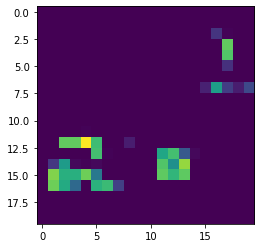

In [11]:
plt.imshow(density)